In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
# sys.version

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)

### Loading the data

In [41]:
input_texts = []
target_texts = []

In [4]:
for line in open("../poetry_generator/data/robert_frost.txt"):
    line = line.rstrip()
    if not line:
        continue
        
    input_line = '<sos>' + line
    target_line = line + '<eos>'
    
    input_texts.append(input_line)
    target_texts.append(target_line)

In [5]:
all_lines = input_texts + target_texts
all_lines[:15]

['<sos>Two roads diverged in a yellow wood,',
 '<sos>And sorry I could not travel both',
 '<sos>And be one traveler, long I stood',
 '<sos>And looked down one as far as I could',
 '<sos>To where it bent in the undergrowth;',
 '<sos>Then took the other, as just as fair,',
 '<sos>And having perhaps the better claim',
 '<sos>Because it was grassy and wanted wear,',
 '<sos>Though as for that the passing there',
 '<sos>Had worn them really about the same,',
 '<sos>And both that morning equally lay',
 '<sos>In leaves no step had trodden black.',
 '<sos>Oh, I kept the first for another day!',
 '<sos>Yet knowing how way leads on to way',
 '<sos>I doubted if I should ever come back.']

In [6]:
len(all_lines)

2872

### Converting sentences into integers and word to integer mapping
#### Tokenizer 1) Splits into individual tokens/words 2) each word is converted into an integer index for mapping 

In [7]:
from keras.preprocessing.text import Tokenizer

MAX_VOCAB_SIZE = 3000
MAX_SEQUENCE_LENGTH = 100

In [8]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

target_sequences[:15]

[[133, 571, 572, 7, 3, 573],
 [4, 574, 5, 66, 28, 984],
 [4, 24, 25, 985, 163, 5],
 [4, 181, 69, 25, 14, 137, 14, 5],
 [2, 39, 8, 986, 7, 1],
 [130, 197, 1, 575, 14, 73, 14],
 [4, 145, 305, 1, 260],
 [440, 8, 12, 576, 4, 244],
 [155, 14, 13, 11, 1, 577, 2280],
 [21, 579, 50, 415, 122, 1],
 [4, 153, 11, 987, 988, 2281],
 [7, 989, 44, 581, 21, 990, 2282],
 [941, 5, 261, 1, 262, 13, 323],
 [191, 992, 106, 80, 993, 15, 2],
 [5, 994, 29, 5, 126, 154, 86, 2283]]

In [9]:
print(input_sequences[:15])

max_seq_len_from_data = max(len(s) for s in input_sequences)
print('Maximum sequence length', max_seq_len_from_data)


[[413, 571, 572, 7, 3, 573, 808], [16, 574, 5, 66, 28, 984, 153], [16, 24, 25, 985, 163, 5, 258], [16, 181, 69, 25, 14, 137, 14, 5, 66], [59, 39, 8, 986, 7, 1, 2408], [259, 197, 1, 575, 14, 73, 14, 2409], [16, 145, 305, 1, 260, 2410], [2411, 8, 12, 576, 4, 244, 2412], [414, 14, 13, 11, 1, 577, 58], [578, 579, 50, 415, 122, 1, 809], [16, 153, 11, 987, 988, 580], [102, 989, 44, 581, 21, 990, 991], [2413, 5, 261, 1, 262, 13, 323, 2414], [810, 992, 106, 80, 993, 15, 2, 80], [30, 994, 29, 5, 126, 154, 86, 324]]
Maximum sequence length 11


#### word to integer mapping

In [10]:
word_to_index = tokenizer.word_index
print('unique tokens =',len(word_to_index))
# assert('<sos>' in word_to_index)
# assert('<eos>' in word_to_index)

unique tokens = 4614


### Padding sequences --> by adding padding tokens, all sequences of varying lengths have same length so that they can be effectively processed by the model

In [11]:
max_seq_len = min(max_seq_len_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_seq_len, padding='post')

In [12]:
print('Input sequence is {} with the size of {}' .format(input_sequences[0], input_sequences.shape[1]))
print('Target sequence is {} with the size of {}' .format(target_sequences[0], target_sequences.shape[1]))

Input sequence is [413 571 572   7   3 573 808   0   0   0   0] with the size of 11
Target sequence is [133 571 572   7   3 573   0   0   0   0   0] with the size of 11


### Load pre-trained word vectors with GloVe and word --> vec mapping

In [13]:
path2glove = os.getcwd() + '/glove/glove.6B.50d.txt'

In [14]:
word2vec = {}
with open(path2glove) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        
    print('Found {} word vectors.' .format(len(word2vec)))

Found 400000 word vectors.


In [15]:
from itertools import islice

word2vec_first_10 = dict(islice(word2vec.items(), 3))

print(word2vec_first_10)

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32), ',': array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
       -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
       -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
       -0.41634 , -0.1542

### Embedding matrix

In [16]:
print('Filling pretrained embeddings...')

Filling pretrained embeddings...


In [17]:
EMBEDDING_DIM = 50

num_words = min(MAX_VOCAB_SIZE, len(word_to_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_to_index.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [20]:
print(embedding_matrix.shape)
embedding_matrix

(3000, 50)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41800001,  0.24968   , -0.41242   , ..., -0.18411   ,
        -0.11514   , -0.78580999],
       [ 0.68046999, -0.039263  ,  0.30186   , ..., -0.073297  ,
        -0.064699  , -0.26043999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### One-hot encoded target 

#### The target is a sequence, so can not pass a sparse categorical cross entropy loss function to keras as I have multiple targets per input

In [21]:
print(input_sequences.shape)
print(max_seq_len)
print(num_words)

(1436, 11)
11
3000


In [29]:
one_hot_targets = np.zeros((len(input_sequences), max_seq_len, num_words))
for i, target_sequence in enumerate(target_sequences):
    for t, word in enumerate(target_sequence):
        if word > 0:
            one_hot_targets[i, t, word] = 1

In [70]:
one_hot_targets[3][0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Load pre-trained word embeddings into an Embedding layer

In [46]:
embedding_layer = Embedding(num_words, 
                            EMBEDDING_DIM, 
                            weights=[embedding_matrix])

### Create an LSTM network with a single LSTM

#### Building a model...

In [72]:
from keras.layers import Dense, Embedding, Input, LSTM

LATENT_DIM = 25
BATCH_SIZE = 128
EPOCHS = 2000
VALIDATION_SPLIT = 0.2

In [60]:
input_ = Input(shape = (max_seq_len,))
input_h = Input(shape = (LATENT_DIM,))
input_c = Input(shape = (LATENT_DIM,))

In [63]:
x = embedding_layer(input_)

# LSTM has to predict rest of the sequence and the output must be a sequence, hence return_sequences=True
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[input_h, input_c])

dense = Dense(num_words, activation='softmax')
output = dense(x)

In [67]:
model = Model([input_, input_h, input_c], output)
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy'])

In [74]:
print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit([input_sequences, z, z],
             one_hot_targets,
             batch_size=BATCH_SIZE,
             epochs=EPOCHS,
             validation_split=VALIDATION_SPLIT)

Training model...
Epoch 1/2000
9/9 [==============================] - 9s 382ms/step - loss: 4.5912 - accuracy: 0.0304 - val_loss: 4.4020 - val_accuracy: 0.0208
Epoch 2/2000
9/9 [==============================] - 2s 179ms/step - loss: 3.9626 - accuracy: 0.0259 - val_loss: 4.3074 - val_accuracy: 0.0246
Epoch 3/2000
9/9 [==============================] - 2s 193ms/step - loss: 3.8150 - accuracy: 0.0365 - val_loss: 4.3041 - val_accuracy: 0.0246
Epoch 4/2000
9/9 [==============================] - 1s 167ms/step - loss: 3.7711 - accuracy: 0.0365 - val_loss: 4.3068 - val_accuracy: 0.0246
Epoch 5/2000
9/9 [==============================] - 2s 225ms/step - loss: 3.7435 - accuracy: 0.0366 - val_loss: 4.2702 - val_accuracy: 0.0246
Epoch 6/2000
9/9 [==============================] - 2s 171ms/step - loss: 3.7031 - accuracy: 0.0365 - val_loss: 4.2200 - val_accuracy: 0.0259
Epoch 7/2000
9/9 [==============================] - 2s 209ms/step - loss: 3.6683 - accuracy: 0.0372 - val_loss: 4.1910 - val_accur

9/9 [==============================] - 2s 169ms/step - loss: 1.4592 - accuracy: 0.3632 - val_loss: 2.7643 - val_accuracy: 0.2778
Epoch 59/2000
9/9 [==============================] - 1s 167ms/step - loss: 1.4409 - accuracy: 0.3667 - val_loss: 2.7551 - val_accuracy: 0.2835
Epoch 60/2000
9/9 [==============================] - 1s 149ms/step - loss: 1.4217 - accuracy: 0.3629 - val_loss: 2.7467 - val_accuracy: 0.2809
Epoch 61/2000
9/9 [==============================] - 2s 177ms/step - loss: 1.4052 - accuracy: 0.3712 - val_loss: 2.7365 - val_accuracy: 0.2771
Epoch 62/2000
9/9 [==============================] - 1s 149ms/step - loss: 1.3858 - accuracy: 0.3632 - val_loss: 2.7308 - val_accuracy: 0.2768
Epoch 63/2000
9/9 [==============================] - 2s 179ms/step - loss: 1.3698 - accuracy: 0.3659 - val_loss: 2.7288 - val_accuracy: 0.2825
Epoch 64/2000
9/9 [==============================] - 1s 174ms/step - loss: 1.3517 - accuracy: 0.3669 - val_loss: 2.7186 - val_accuracy: 0.2803
Epoch 65/2000

9/9 [==============================] - 2s 168ms/step - loss: 0.9357 - accuracy: 0.4250 - val_loss: 2.5809 - val_accuracy: 0.3172
Epoch 116/2000
9/9 [==============================] - 1s 165ms/step - loss: 0.9314 - accuracy: 0.4279 - val_loss: 2.5838 - val_accuracy: 0.3163
Epoch 117/2000
9/9 [==============================] - 1s 169ms/step - loss: 0.9286 - accuracy: 0.4279 - val_loss: 2.5818 - val_accuracy: 0.3213
Epoch 118/2000
9/9 [==============================] - 1s 152ms/step - loss: 0.9253 - accuracy: 0.4280 - val_loss: 2.5824 - val_accuracy: 0.3204
Epoch 119/2000
9/9 [==============================] - 1s 159ms/step - loss: 0.9190 - accuracy: 0.4312 - val_loss: 2.5781 - val_accuracy: 0.3179
Epoch 120/2000
9/9 [==============================] - 2s 172ms/step - loss: 0.9156 - accuracy: 0.4341 - val_loss: 2.5813 - val_accuracy: 0.3217
Epoch 121/2000
9/9 [==============================] - 2s 182ms/step - loss: 0.9132 - accuracy: 0.4297 - val_loss: 2.5814 - val_accuracy: 0.3210
Epoch 1

Epoch 172/2000
9/9 [==============================] - 1s 171ms/step - loss: 0.6947 - accuracy: 0.4809 - val_loss: 2.5759 - val_accuracy: 0.3472
Epoch 173/2000
9/9 [==============================] - 1s 157ms/step - loss: 0.6893 - accuracy: 0.4786 - val_loss: 2.5846 - val_accuracy: 0.3469
Epoch 174/2000
9/9 [==============================] - 1s 147ms/step - loss: 0.6885 - accuracy: 0.4811 - val_loss: 2.5929 - val_accuracy: 0.3460
Epoch 175/2000
9/9 [==============================] - 2s 199ms/step - loss: 0.6861 - accuracy: 0.4805 - val_loss: 2.5851 - val_accuracy: 0.3479
Epoch 176/2000
9/9 [==============================] - 1s 161ms/step - loss: 0.6820 - accuracy: 0.4831 - val_loss: 2.5885 - val_accuracy: 0.3479
Epoch 177/2000
9/9 [==============================] - 2s 168ms/step - loss: 0.6767 - accuracy: 0.4828 - val_loss: 2.5869 - val_accuracy: 0.3497
Epoch 178/2000
9/9 [==============================] - 1s 148ms/step - loss: 0.6708 - accuracy: 0.4846 - val_loss: 2.5966 - val_accuracy:

Epoch 229/2000
9/9 [==============================] - 2s 187ms/step - loss: 0.5490 - accuracy: 0.5140 - val_loss: 2.6145 - val_accuracy: 0.3595
Epoch 230/2000
9/9 [==============================] - 1s 174ms/step - loss: 0.5442 - accuracy: 0.5153 - val_loss: 2.6112 - val_accuracy: 0.3611
Epoch 231/2000
9/9 [==============================] - 1s 167ms/step - loss: 0.5436 - accuracy: 0.5157 - val_loss: 2.6104 - val_accuracy: 0.3580
Epoch 232/2000
9/9 [==============================] - 2s 187ms/step - loss: 0.5427 - accuracy: 0.5154 - val_loss: 2.6275 - val_accuracy: 0.3567
Epoch 233/2000
9/9 [==============================] - 2s 172ms/step - loss: 0.5410 - accuracy: 0.5154 - val_loss: 2.6156 - val_accuracy: 0.3608
Epoch 234/2000
9/9 [==============================] - 2s 203ms/step - loss: 0.5392 - accuracy: 0.5161 - val_loss: 2.6097 - val_accuracy: 0.3592
Epoch 235/2000
9/9 [==============================] - 2s 171ms/step - loss: 0.5374 - accuracy: 0.5158 - val_loss: 2.6212 - val_accuracy:

Epoch 286/2000
9/9 [==============================] - 2s 177ms/step - loss: 0.4827 - accuracy: 0.5233 - val_loss: 2.6970 - val_accuracy: 0.3602
Epoch 287/2000
9/9 [==============================] - 2s 182ms/step - loss: 0.4800 - accuracy: 0.5234 - val_loss: 2.6858 - val_accuracy: 0.3605
Epoch 288/2000
9/9 [==============================] - 1s 164ms/step - loss: 0.4804 - accuracy: 0.5242 - val_loss: 2.6994 - val_accuracy: 0.3583
Epoch 289/2000
9/9 [==============================] - 2s 179ms/step - loss: 0.4809 - accuracy: 0.5244 - val_loss: 2.6882 - val_accuracy: 0.3614
Epoch 290/2000
9/9 [==============================] - 1s 159ms/step - loss: 0.4779 - accuracy: 0.5242 - val_loss: 2.6933 - val_accuracy: 0.3602
Epoch 291/2000
9/9 [==============================] - 2s 195ms/step - loss: 0.4794 - accuracy: 0.5243 - val_loss: 2.7030 - val_accuracy: 0.3567
Epoch 292/2000
9/9 [==============================] - 2s 196ms/step - loss: 0.4785 - accuracy: 0.5244 - val_loss: 2.6996 - val_accuracy:

Epoch 343/2000
9/9 [==============================] - 2s 178ms/step - loss: 0.4392 - accuracy: 0.5315 - val_loss: 2.7718 - val_accuracy: 0.3523
Epoch 344/2000
9/9 [==============================] - 2s 182ms/step - loss: 0.4417 - accuracy: 0.5314 - val_loss: 2.7785 - val_accuracy: 0.3501
Epoch 345/2000
9/9 [==============================] - 2s 190ms/step - loss: 0.4396 - accuracy: 0.5331 - val_loss: 2.7771 - val_accuracy: 0.3545
Epoch 346/2000
9/9 [==============================] - 2s 181ms/step - loss: 0.4382 - accuracy: 0.5329 - val_loss: 2.7857 - val_accuracy: 0.3497
Epoch 347/2000
9/9 [==============================] - 2s 196ms/step - loss: 0.4388 - accuracy: 0.5325 - val_loss: 2.7857 - val_accuracy: 0.3479
Epoch 348/2000
9/9 [==============================] - 2s 206ms/step - loss: 0.4361 - accuracy: 0.5333 - val_loss: 2.7834 - val_accuracy: 0.3551
Epoch 349/2000
9/9 [==============================] - 2s 183ms/step - loss: 0.4364 - accuracy: 0.5329 - val_loss: 2.7862 - val_accuracy:

Epoch 400/2000
9/9 [==============================] - 3s 293ms/step - loss: 0.4076 - accuracy: 0.5381 - val_loss: 2.8700 - val_accuracy: 0.3479
Epoch 401/2000
9/9 [==============================] - 3s 341ms/step - loss: 0.4055 - accuracy: 0.5387 - val_loss: 2.8717 - val_accuracy: 0.3497
Epoch 402/2000
9/9 [==============================] - 4s 389ms/step - loss: 0.4064 - accuracy: 0.5380 - val_loss: 2.8695 - val_accuracy: 0.3485
Epoch 403/2000
9/9 [==============================] - 3s 352ms/step - loss: 0.4058 - accuracy: 0.5385 - val_loss: 2.8709 - val_accuracy: 0.3485
Epoch 404/2000
9/9 [==============================] - 3s 399ms/step - loss: 0.4050 - accuracy: 0.5385 - val_loss: 2.8744 - val_accuracy: 0.3494
Epoch 405/2000
9/9 [==============================] - 3s 380ms/step - loss: 0.4049 - accuracy: 0.5386 - val_loss: 2.8708 - val_accuracy: 0.3453
Epoch 406/2000
9/9 [==============================] - 4s 455ms/step - loss: 0.4030 - accuracy: 0.5382 - val_loss: 2.8752 - val_accuracy:

Epoch 457/2000
9/9 [==============================] - 3s 359ms/step - loss: 0.3756 - accuracy: 0.5474 - val_loss: 2.9829 - val_accuracy: 0.3485
Epoch 458/2000
9/9 [==============================] - 4s 435ms/step - loss: 0.3758 - accuracy: 0.5477 - val_loss: 2.9831 - val_accuracy: 0.3510
Epoch 459/2000
9/9 [==============================] - 2s 255ms/step - loss: 0.3759 - accuracy: 0.5468 - val_loss: 2.9916 - val_accuracy: 0.3472
Epoch 460/2000
9/9 [==============================] - 3s 353ms/step - loss: 0.3754 - accuracy: 0.5475 - val_loss: 2.9764 - val_accuracy: 0.3504
Epoch 461/2000
9/9 [==============================] - 4s 486ms/step - loss: 0.3755 - accuracy: 0.5468 - val_loss: 2.9938 - val_accuracy: 0.3460
Epoch 462/2000
9/9 [==============================] - 4s 405ms/step - loss: 0.3792 - accuracy: 0.5470 - val_loss: 2.9979 - val_accuracy: 0.3469
Epoch 463/2000
9/9 [==============================] - 4s 429ms/step - loss: 0.3785 - accuracy: 0.5468 - val_loss: 3.0187 - val_accuracy:

Epoch 514/2000
9/9 [==============================] - 3s 319ms/step - loss: 0.3610 - accuracy: 0.5489 - val_loss: 3.0433 - val_accuracy: 0.3447
Epoch 515/2000
9/9 [==============================] - 3s 373ms/step - loss: 0.3598 - accuracy: 0.5494 - val_loss: 3.0353 - val_accuracy: 0.3447
Epoch 516/2000
9/9 [==============================] - 4s 421ms/step - loss: 0.3607 - accuracy: 0.5490 - val_loss: 3.0550 - val_accuracy: 0.3460
Epoch 517/2000
9/9 [==============================] - 4s 464ms/step - loss: 0.3597 - accuracy: 0.5495 - val_loss: 3.0367 - val_accuracy: 0.3460
Epoch 518/2000
9/9 [==============================] - 4s 419ms/step - loss: 0.3579 - accuracy: 0.5500 - val_loss: 3.0410 - val_accuracy: 0.3469
Epoch 519/2000
9/9 [==============================] - 4s 486ms/step - loss: 0.3575 - accuracy: 0.5495 - val_loss: 3.0369 - val_accuracy: 0.3456
Epoch 520/2000
9/9 [==============================] - 4s 414ms/step - loss: 0.3575 - accuracy: 0.5503 - val_loss: 3.0421 - val_accuracy:

Epoch 571/2000
9/9 [==============================] - 3s 383ms/step - loss: 0.3417 - accuracy: 0.5512 - val_loss: 3.0761 - val_accuracy: 0.3453
Epoch 572/2000
9/9 [==============================] - 3s 296ms/step - loss: 0.3438 - accuracy: 0.5505 - val_loss: 3.0780 - val_accuracy: 0.3460
Epoch 573/2000
9/9 [==============================] - 3s 329ms/step - loss: 0.3415 - accuracy: 0.5514 - val_loss: 3.0749 - val_accuracy: 0.3472
Epoch 574/2000
9/9 [==============================] - 2s 278ms/step - loss: 0.3405 - accuracy: 0.5510 - val_loss: 3.0827 - val_accuracy: 0.3447
Epoch 575/2000
9/9 [==============================] - 3s 374ms/step - loss: 0.3415 - accuracy: 0.5514 - val_loss: 3.0656 - val_accuracy: 0.3472
Epoch 576/2000
9/9 [==============================] - 4s 420ms/step - loss: 0.3417 - accuracy: 0.5516 - val_loss: 3.0772 - val_accuracy: 0.3422
Epoch 577/2000
9/9 [==============================] - 3s 332ms/step - loss: 0.3414 - accuracy: 0.5522 - val_loss: 3.0696 - val_accuracy:

Epoch 628/2000
9/9 [==============================] - 2s 190ms/step - loss: 0.3288 - accuracy: 0.5524 - val_loss: 3.1069 - val_accuracy: 0.3374
Epoch 629/2000
9/9 [==============================] - 2s 188ms/step - loss: 0.3272 - accuracy: 0.5525 - val_loss: 3.1167 - val_accuracy: 0.3381
Epoch 630/2000
9/9 [==============================] - 2s 186ms/step - loss: 0.3296 - accuracy: 0.5520 - val_loss: 3.1162 - val_accuracy: 0.3365
Epoch 631/2000
9/9 [==============================] - 2s 183ms/step - loss: 0.3291 - accuracy: 0.5520 - val_loss: 3.1260 - val_accuracy: 0.3343
Epoch 632/2000
9/9 [==============================] - 2s 190ms/step - loss: 0.3278 - accuracy: 0.5523 - val_loss: 3.1171 - val_accuracy: 0.3349
Epoch 633/2000
9/9 [==============================] - 2s 184ms/step - loss: 0.3290 - accuracy: 0.5519 - val_loss: 3.1202 - val_accuracy: 0.3352
Epoch 634/2000
9/9 [==============================] - 2s 199ms/step - loss: 0.3266 - accuracy: 0.5519 - val_loss: 3.1148 - val_accuracy:

Epoch 685/2000
9/9 [==============================] - 2s 177ms/step - loss: 0.3233 - accuracy: 0.5518 - val_loss: 3.1303 - val_accuracy: 0.3359
Epoch 686/2000
9/9 [==============================] - 1s 167ms/step - loss: 0.3224 - accuracy: 0.5519 - val_loss: 3.1423 - val_accuracy: 0.3371
Epoch 687/2000
9/9 [==============================] - 2s 181ms/step - loss: 0.3224 - accuracy: 0.5517 - val_loss: 3.1419 - val_accuracy: 0.3403
Epoch 688/2000
9/9 [==============================] - 2s 217ms/step - loss: 0.3246 - accuracy: 0.5512 - val_loss: 3.1361 - val_accuracy: 0.3355
Epoch 689/2000
9/9 [==============================] - 2s 178ms/step - loss: 0.3267 - accuracy: 0.5507 - val_loss: 3.1436 - val_accuracy: 0.3359
Epoch 690/2000
9/9 [==============================] - 2s 180ms/step - loss: 0.3259 - accuracy: 0.5511 - val_loss: 3.1351 - val_accuracy: 0.3359
Epoch 691/2000
9/9 [==============================] - 2s 204ms/step - loss: 0.3249 - accuracy: 0.5508 - val_loss: 3.1287 - val_accuracy:

Epoch 742/2000
9/9 [==============================] - 2s 180ms/step - loss: 0.3158 - accuracy: 0.5530 - val_loss: 3.1827 - val_accuracy: 0.3311
Epoch 743/2000
9/9 [==============================] - 2s 202ms/step - loss: 0.3161 - accuracy: 0.5525 - val_loss: 3.1887 - val_accuracy: 0.3336
Epoch 744/2000
9/9 [==============================] - 2s 181ms/step - loss: 0.3147 - accuracy: 0.5527 - val_loss: 3.1919 - val_accuracy: 0.3330
Epoch 745/2000
9/9 [==============================] - 2s 188ms/step - loss: 0.3147 - accuracy: 0.5531 - val_loss: 3.1828 - val_accuracy: 0.3349
Epoch 746/2000
9/9 [==============================] - 2s 193ms/step - loss: 0.3154 - accuracy: 0.5524 - val_loss: 3.2003 - val_accuracy: 0.3324
Epoch 747/2000
9/9 [==============================] - 2s 193ms/step - loss: 0.3170 - accuracy: 0.5519 - val_loss: 3.1967 - val_accuracy: 0.3330
Epoch 748/2000
9/9 [==============================] - 2s 194ms/step - loss: 0.3151 - accuracy: 0.5530 - val_loss: 3.1905 - val_accuracy:

Epoch 799/2000
9/9 [==============================] - 2s 205ms/step - loss: 0.3265 - accuracy: 0.5497 - val_loss: 3.3093 - val_accuracy: 0.3235
Epoch 800/2000
9/9 [==============================] - 2s 196ms/step - loss: 0.3204 - accuracy: 0.5514 - val_loss: 3.2889 - val_accuracy: 0.3267
Epoch 801/2000
9/9 [==============================] - 2s 184ms/step - loss: 0.3177 - accuracy: 0.5517 - val_loss: 3.2791 - val_accuracy: 0.3295
Epoch 802/2000
9/9 [==============================] - 2s 179ms/step - loss: 0.3219 - accuracy: 0.5511 - val_loss: 3.3099 - val_accuracy: 0.3277
Epoch 803/2000
9/9 [==============================] - 2s 197ms/step - loss: 0.3311 - accuracy: 0.5488 - val_loss: 3.3044 - val_accuracy: 0.3289
Epoch 804/2000
9/9 [==============================] - 2s 186ms/step - loss: 0.3315 - accuracy: 0.5484 - val_loss: 3.3087 - val_accuracy: 0.3254
Epoch 805/2000
9/9 [==============================] - 2s 172ms/step - loss: 0.3274 - accuracy: 0.5506 - val_loss: 3.3130 - val_accuracy:

Epoch 856/2000
9/9 [==============================] - 2s 176ms/step - loss: 0.3390 - accuracy: 0.5485 - val_loss: 3.3118 - val_accuracy: 0.3302
Epoch 857/2000
9/9 [==============================] - 2s 181ms/step - loss: 0.3348 - accuracy: 0.5468 - val_loss: 3.3049 - val_accuracy: 0.3289
Epoch 858/2000
9/9 [==============================] - 2s 182ms/step - loss: 0.3345 - accuracy: 0.5469 - val_loss: 3.2949 - val_accuracy: 0.3289
Epoch 859/2000
9/9 [==============================] - 1s 170ms/step - loss: 0.3308 - accuracy: 0.5480 - val_loss: 3.3142 - val_accuracy: 0.3267
Epoch 860/2000
9/9 [==============================] - 2s 177ms/step - loss: 0.3392 - accuracy: 0.5466 - val_loss: 3.2997 - val_accuracy: 0.3286
Epoch 861/2000
9/9 [==============================] - 2s 183ms/step - loss: 0.3389 - accuracy: 0.5458 - val_loss: 3.3035 - val_accuracy: 0.3251
Epoch 862/2000
9/9 [==============================] - 2s 182ms/step - loss: 0.3391 - accuracy: 0.5461 - val_loss: 3.3053 - val_accuracy:

Epoch 913/2000
9/9 [==============================] - 2s 179ms/step - loss: 0.3115 - accuracy: 0.5518 - val_loss: 3.3617 - val_accuracy: 0.3223
Epoch 914/2000
9/9 [==============================] - 1s 171ms/step - loss: 0.3104 - accuracy: 0.5519 - val_loss: 3.3516 - val_accuracy: 0.3213
Epoch 915/2000
9/9 [==============================] - 1s 167ms/step - loss: 0.3096 - accuracy: 0.5515 - val_loss: 3.3577 - val_accuracy: 0.3213
Epoch 916/2000
9/9 [==============================] - 2s 190ms/step - loss: 0.3100 - accuracy: 0.5517 - val_loss: 3.3595 - val_accuracy: 0.3235
Epoch 917/2000
9/9 [==============================] - 2s 174ms/step - loss: 0.3105 - accuracy: 0.5519 - val_loss: 3.3616 - val_accuracy: 0.3191
Epoch 918/2000
9/9 [==============================] - 2s 190ms/step - loss: 0.3103 - accuracy: 0.5517 - val_loss: 3.3459 - val_accuracy: 0.3232
Epoch 919/2000
9/9 [==============================] - 2s 166ms/step - loss: 0.3079 - accuracy: 0.5518 - val_loss: 3.3626 - val_accuracy:

Epoch 970/2000
9/9 [==============================] - 2s 196ms/step - loss: 0.3030 - accuracy: 0.5519 - val_loss: 3.3972 - val_accuracy: 0.3204
Epoch 971/2000
9/9 [==============================] - 1s 162ms/step - loss: 0.3054 - accuracy: 0.5512 - val_loss: 3.4020 - val_accuracy: 0.3194
Epoch 972/2000
9/9 [==============================] - 2s 181ms/step - loss: 0.3014 - accuracy: 0.5521 - val_loss: 3.3944 - val_accuracy: 0.3194
Epoch 973/2000
9/9 [==============================] - 2s 222ms/step - loss: 0.3042 - accuracy: 0.5512 - val_loss: 3.4031 - val_accuracy: 0.3188
Epoch 974/2000
9/9 [==============================] - 2s 185ms/step - loss: 0.3055 - accuracy: 0.5513 - val_loss: 3.3984 - val_accuracy: 0.3169
Epoch 975/2000
9/9 [==============================] - 1s 159ms/step - loss: 0.3055 - accuracy: 0.5519 - val_loss: 3.4031 - val_accuracy: 0.3210
Epoch 976/2000
9/9 [==============================] - 2s 203ms/step - loss: 0.3041 - accuracy: 0.5517 - val_loss: 3.3961 - val_accuracy:

Epoch 1027/2000
9/9 [==============================] - 2s 171ms/step - loss: 0.2960 - accuracy: 0.5526 - val_loss: 3.4475 - val_accuracy: 0.3185
Epoch 1028/2000
9/9 [==============================] - 1s 164ms/step - loss: 0.2980 - accuracy: 0.5528 - val_loss: 3.4495 - val_accuracy: 0.3153
Epoch 1029/2000
9/9 [==============================] - 2s 169ms/step - loss: 0.2978 - accuracy: 0.5527 - val_loss: 3.4289 - val_accuracy: 0.3185
Epoch 1030/2000
9/9 [==============================] - 2s 171ms/step - loss: 0.2956 - accuracy: 0.5534 - val_loss: 3.4420 - val_accuracy: 0.3188
Epoch 1031/2000
9/9 [==============================] - 1s 161ms/step - loss: 0.2969 - accuracy: 0.5531 - val_loss: 3.4440 - val_accuracy: 0.3182
Epoch 1032/2000
9/9 [==============================] - 2s 198ms/step - loss: 0.2966 - accuracy: 0.5528 - val_loss: 3.4619 - val_accuracy: 0.3125
Epoch 1033/2000
9/9 [==============================] - 2s 191ms/step - loss: 0.2980 - accuracy: 0.5519 - val_loss: 3.4415 - val_ac

9/9 [==============================] - 2s 180ms/step - loss: 0.3297 - accuracy: 0.5441 - val_loss: 3.4248 - val_accuracy: 0.3103
Epoch 1084/2000
9/9 [==============================] - 2s 185ms/step - loss: 0.3284 - accuracy: 0.5439 - val_loss: 3.4214 - val_accuracy: 0.3131
Epoch 1085/2000
9/9 [==============================] - 2s 177ms/step - loss: 0.3255 - accuracy: 0.5448 - val_loss: 3.4089 - val_accuracy: 0.3166
Epoch 1086/2000
9/9 [==============================] - 2s 178ms/step - loss: 0.3221 - accuracy: 0.5455 - val_loss: 3.4131 - val_accuracy: 0.3147
Epoch 1087/2000
9/9 [==============================] - 2s 191ms/step - loss: 0.3209 - accuracy: 0.5454 - val_loss: 3.4081 - val_accuracy: 0.3160
Epoch 1088/2000
9/9 [==============================] - 2s 186ms/step - loss: 0.3169 - accuracy: 0.5462 - val_loss: 3.4121 - val_accuracy: 0.3147
Epoch 1089/2000
9/9 [==============================] - 2s 242ms/step - loss: 0.3174 - accuracy: 0.5484 - val_loss: 3.4111 - val_accuracy: 0.3172
E

9/9 [==============================] - 2s 173ms/step - loss: 0.3010 - accuracy: 0.5522 - val_loss: 3.4375 - val_accuracy: 0.3242
Epoch 1140/2000
9/9 [==============================] - 2s 176ms/step - loss: 0.3011 - accuracy: 0.5528 - val_loss: 3.4391 - val_accuracy: 0.3239
Epoch 1141/2000
9/9 [==============================] - 2s 173ms/step - loss: 0.2998 - accuracy: 0.5527 - val_loss: 3.4387 - val_accuracy: 0.3220
Epoch 1142/2000
9/9 [==============================] - 2s 172ms/step - loss: 0.3001 - accuracy: 0.5526 - val_loss: 3.4400 - val_accuracy: 0.3188
Epoch 1143/2000
9/9 [==============================] - 2s 190ms/step - loss: 0.2997 - accuracy: 0.5526 - val_loss: 3.4392 - val_accuracy: 0.3198
Epoch 1144/2000
9/9 [==============================] - 2s 165ms/step - loss: 0.2999 - accuracy: 0.5530 - val_loss: 3.4419 - val_accuracy: 0.3217
Epoch 1145/2000
9/9 [==============================] - 2s 195ms/step - loss: 0.2989 - accuracy: 0.5526 - val_loss: 3.4430 - val_accuracy: 0.3210
E

9/9 [==============================] - 2s 179ms/step - loss: 0.2938 - accuracy: 0.5531 - val_loss: 3.4777 - val_accuracy: 0.3179
Epoch 1196/2000
9/9 [==============================] - 2s 171ms/step - loss: 0.2945 - accuracy: 0.5535 - val_loss: 3.4798 - val_accuracy: 0.3182
Epoch 1197/2000
9/9 [==============================] - 3s 294ms/step - loss: 0.2952 - accuracy: 0.5534 - val_loss: 3.4705 - val_accuracy: 0.3176
Epoch 1198/2000
9/9 [==============================] - 2s 282ms/step - loss: 0.3000 - accuracy: 0.5508 - val_loss: 3.4889 - val_accuracy: 0.3122
Epoch 1199/2000
9/9 [==============================] - 2s 189ms/step - loss: 0.3024 - accuracy: 0.5508 - val_loss: 3.4569 - val_accuracy: 0.3176
Epoch 1200/2000
9/9 [==============================] - 1s 168ms/step - loss: 0.3038 - accuracy: 0.5499 - val_loss: 3.4584 - val_accuracy: 0.3172
Epoch 1201/2000
9/9 [==============================] - 2s 195ms/step - loss: 0.2996 - accuracy: 0.5512 - val_loss: 3.4703 - val_accuracy: 0.3201
E

9/9 [==============================] - 2s 181ms/step - loss: 0.3021 - accuracy: 0.5511 - val_loss: 3.5794 - val_accuracy: 0.3087
Epoch 1252/2000
9/9 [==============================] - 2s 186ms/step - loss: 0.3043 - accuracy: 0.5508 - val_loss: 3.5813 - val_accuracy: 0.3103
Epoch 1253/2000
9/9 [==============================] - 1s 163ms/step - loss: 0.3015 - accuracy: 0.5512 - val_loss: 3.5933 - val_accuracy: 0.3084
Epoch 1254/2000
9/9 [==============================] - 2s 188ms/step - loss: 0.3047 - accuracy: 0.5507 - val_loss: 3.5923 - val_accuracy: 0.3106
Epoch 1255/2000
9/9 [==============================] - 2s 178ms/step - loss: 0.3021 - accuracy: 0.5512 - val_loss: 3.5898 - val_accuracy: 0.3100
Epoch 1256/2000
9/9 [==============================] - 2s 170ms/step - loss: 0.3006 - accuracy: 0.5516 - val_loss: 3.5952 - val_accuracy: 0.3138
Epoch 1257/2000
9/9 [==============================] - 2s 182ms/step - loss: 0.2997 - accuracy: 0.5518 - val_loss: 3.5877 - val_accuracy: 0.3084
E

9/9 [==============================] - 2s 202ms/step - loss: 0.2949 - accuracy: 0.5532 - val_loss: 3.6343 - val_accuracy: 0.3106
Epoch 1308/2000
9/9 [==============================] - 2s 194ms/step - loss: 0.2963 - accuracy: 0.5530 - val_loss: 3.6421 - val_accuracy: 0.3106
Epoch 1309/2000
9/9 [==============================] - 2s 169ms/step - loss: 0.2950 - accuracy: 0.5535 - val_loss: 3.6388 - val_accuracy: 0.3074
Epoch 1310/2000
9/9 [==============================] - 2s 202ms/step - loss: 0.2930 - accuracy: 0.5532 - val_loss: 3.6383 - val_accuracy: 0.3071
Epoch 1311/2000
9/9 [==============================] - 2s 183ms/step - loss: 0.2929 - accuracy: 0.5533 - val_loss: 3.6392 - val_accuracy: 0.3087
Epoch 1312/2000
9/9 [==============================] - 2s 195ms/step - loss: 0.2926 - accuracy: 0.5535 - val_loss: 3.6483 - val_accuracy: 0.3071
Epoch 1313/2000
9/9 [==============================] - 2s 188ms/step - loss: 0.2931 - accuracy: 0.5536 - val_loss: 3.6449 - val_accuracy: 0.3087
E

9/9 [==============================] - 2s 192ms/step - loss: 0.2934 - accuracy: 0.5534 - val_loss: 3.7074 - val_accuracy: 0.3052
Epoch 1364/2000
9/9 [==============================] - 2s 186ms/step - loss: 0.2947 - accuracy: 0.5532 - val_loss: 3.7072 - val_accuracy: 0.3078
Epoch 1365/2000
9/9 [==============================] - 2s 185ms/step - loss: 0.2915 - accuracy: 0.5530 - val_loss: 3.7177 - val_accuracy: 0.3052
Epoch 1366/2000
9/9 [==============================] - 2s 192ms/step - loss: 0.3028 - accuracy: 0.5514 - val_loss: 3.7464 - val_accuracy: 0.2983
Epoch 1367/2000
9/9 [==============================] - 2s 186ms/step - loss: 0.3087 - accuracy: 0.5495 - val_loss: 3.7031 - val_accuracy: 0.2996
Epoch 1368/2000
9/9 [==============================] - 2s 179ms/step - loss: 0.3119 - accuracy: 0.5492 - val_loss: 3.6962 - val_accuracy: 0.3018
Epoch 1369/2000
9/9 [==============================] - 2s 183ms/step - loss: 0.3067 - accuracy: 0.5512 - val_loss: 3.6596 - val_accuracy: 0.3049
E

9/9 [==============================] - 1s 160ms/step - loss: 0.2907 - accuracy: 0.5535 - val_loss: 3.7579 - val_accuracy: 0.3037
Epoch 1420/2000
9/9 [==============================] - 1s 146ms/step - loss: 0.2911 - accuracy: 0.5526 - val_loss: 3.7648 - val_accuracy: 0.2999
Epoch 1421/2000
9/9 [==============================] - 2s 174ms/step - loss: 0.2919 - accuracy: 0.5525 - val_loss: 3.7579 - val_accuracy: 0.3027
Epoch 1422/2000
9/9 [==============================] - 2s 178ms/step - loss: 0.2906 - accuracy: 0.5535 - val_loss: 3.7618 - val_accuracy: 0.3005
Epoch 1423/2000
9/9 [==============================] - 1s 167ms/step - loss: 0.2900 - accuracy: 0.5535 - val_loss: 3.7643 - val_accuracy: 0.3018
Epoch 1424/2000
9/9 [==============================] - 1s 167ms/step - loss: 0.2894 - accuracy: 0.5537 - val_loss: 3.7648 - val_accuracy: 0.3021
Epoch 1425/2000
9/9 [==============================] - 1s 169ms/step - loss: 0.2901 - accuracy: 0.5532 - val_loss: 3.7656 - val_accuracy: 0.3008
E

9/9 [==============================] - 2s 241ms/step - loss: 0.3290 - accuracy: 0.5459 - val_loss: 3.7469 - val_accuracy: 0.2983
Epoch 1476/2000
9/9 [==============================] - 2s 189ms/step - loss: 0.3655 - accuracy: 0.5404 - val_loss: 3.7852 - val_accuracy: 0.2970
Epoch 1477/2000
9/9 [==============================] - 2s 167ms/step - loss: 0.3604 - accuracy: 0.5401 - val_loss: 3.7539 - val_accuracy: 0.3008
Epoch 1478/2000
9/9 [==============================] - 2s 174ms/step - loss: 0.3420 - accuracy: 0.5424 - val_loss: 3.7298 - val_accuracy: 0.2996
Epoch 1479/2000
9/9 [==============================] - 2s 188ms/step - loss: 0.3360 - accuracy: 0.5429 - val_loss: 3.7508 - val_accuracy: 0.3046
Epoch 1480/2000
9/9 [==============================] - 2s 204ms/step - loss: 0.3333 - accuracy: 0.5443 - val_loss: 3.7713 - val_accuracy: 0.3002
Epoch 1481/2000
9/9 [==============================] - 2s 177ms/step - loss: 0.3286 - accuracy: 0.5466 - val_loss: 3.7585 - val_accuracy: 0.3033
E

9/9 [==============================] - 2s 198ms/step - loss: 0.3033 - accuracy: 0.5521 - val_loss: 3.7495 - val_accuracy: 0.3040
Epoch 1532/2000
9/9 [==============================] - 2s 178ms/step - loss: 0.3030 - accuracy: 0.5518 - val_loss: 3.7545 - val_accuracy: 0.2992
Epoch 1533/2000
9/9 [==============================] - 1s 160ms/step - loss: 0.3036 - accuracy: 0.5512 - val_loss: 3.7617 - val_accuracy: 0.2989
Epoch 1534/2000
9/9 [==============================] - 2s 205ms/step - loss: 0.3035 - accuracy: 0.5517 - val_loss: 3.7636 - val_accuracy: 0.2986
Epoch 1535/2000
9/9 [==============================] - 2s 186ms/step - loss: 0.3031 - accuracy: 0.5519 - val_loss: 3.7744 - val_accuracy: 0.2973
Epoch 1536/2000
9/9 [==============================] - 2s 184ms/step - loss: 0.3033 - accuracy: 0.5518 - val_loss: 3.7712 - val_accuracy: 0.2992
Epoch 1537/2000
9/9 [==============================] - 2s 177ms/step - loss: 0.3025 - accuracy: 0.5518 - val_loss: 3.7767 - val_accuracy: 0.2980
E

9/9 [==============================] - 2s 168ms/step - loss: 0.3025 - accuracy: 0.5512 - val_loss: 3.8270 - val_accuracy: 0.2980
Epoch 1588/2000
9/9 [==============================] - 1s 153ms/step - loss: 0.3022 - accuracy: 0.5518 - val_loss: 3.8278 - val_accuracy: 0.2970
Epoch 1589/2000
9/9 [==============================] - 1s 151ms/step - loss: 0.3026 - accuracy: 0.5517 - val_loss: 3.8254 - val_accuracy: 0.2992
Epoch 1590/2000
9/9 [==============================] - 2s 184ms/step - loss: 0.3009 - accuracy: 0.5523 - val_loss: 3.8324 - val_accuracy: 0.2967
Epoch 1591/2000
9/9 [==============================] - 2s 175ms/step - loss: 0.3013 - accuracy: 0.5526 - val_loss: 3.8363 - val_accuracy: 0.2986
Epoch 1592/2000
9/9 [==============================] - 2s 182ms/step - loss: 0.3007 - accuracy: 0.5527 - val_loss: 3.8358 - val_accuracy: 0.2983
Epoch 1593/2000
9/9 [==============================] - 2s 178ms/step - loss: 0.3005 - accuracy: 0.5519 - val_loss: 3.8447 - val_accuracy: 0.2973
E

9/9 [==============================] - 2s 186ms/step - loss: 0.2977 - accuracy: 0.5513 - val_loss: 3.8954 - val_accuracy: 0.2967
Epoch 1644/2000
9/9 [==============================] - 2s 176ms/step - loss: 0.2973 - accuracy: 0.5515 - val_loss: 3.8967 - val_accuracy: 0.2973
Epoch 1645/2000
9/9 [==============================] - 2s 197ms/step - loss: 0.2969 - accuracy: 0.5517 - val_loss: 3.8948 - val_accuracy: 0.2970
Epoch 1646/2000
9/9 [==============================] - 1s 169ms/step - loss: 0.2982 - accuracy: 0.5516 - val_loss: 3.8992 - val_accuracy: 0.2973
Epoch 1647/2000
9/9 [==============================] - 2s 181ms/step - loss: 0.2974 - accuracy: 0.5518 - val_loss: 3.8983 - val_accuracy: 0.2961
Epoch 1648/2000
9/9 [==============================] - 2s 184ms/step - loss: 0.2974 - accuracy: 0.5523 - val_loss: 3.8910 - val_accuracy: 0.2955
Epoch 1649/2000
9/9 [==============================] - 2s 200ms/step - loss: 0.2949 - accuracy: 0.5525 - val_loss: 3.9037 - val_accuracy: 0.2926
E

9/9 [==============================] - 2s 175ms/step - loss: 0.2975 - accuracy: 0.5526 - val_loss: 3.9384 - val_accuracy: 0.2895
Epoch 1700/2000
9/9 [==============================] - 2s 191ms/step - loss: 0.2945 - accuracy: 0.5529 - val_loss: 3.9458 - val_accuracy: 0.2898
Epoch 1701/2000
9/9 [==============================] - 2s 180ms/step - loss: 0.2959 - accuracy: 0.5519 - val_loss: 3.9409 - val_accuracy: 0.2895
Epoch 1702/2000
9/9 [==============================] - 2s 226ms/step - loss: 0.2952 - accuracy: 0.5533 - val_loss: 3.9311 - val_accuracy: 0.2907
Epoch 1703/2000
9/9 [==============================] - 3s 293ms/step - loss: 0.2936 - accuracy: 0.5538 - val_loss: 3.9363 - val_accuracy: 0.2879
Epoch 1704/2000
9/9 [==============================] - 2s 179ms/step - loss: 0.2938 - accuracy: 0.5527 - val_loss: 3.9381 - val_accuracy: 0.2926
Epoch 1705/2000
9/9 [==============================] - 2s 170ms/step - loss: 0.2924 - accuracy: 0.5538 - val_loss: 3.9347 - val_accuracy: 0.2914
E

9/9 [==============================] - 2s 234ms/step - loss: 0.3027 - accuracy: 0.5527 - val_loss: 4.0045 - val_accuracy: 0.2929
Epoch 1756/2000
9/9 [==============================] - 2s 199ms/step - loss: 0.3050 - accuracy: 0.5522 - val_loss: 3.9896 - val_accuracy: 0.2914
Epoch 1757/2000
9/9 [==============================] - 2s 164ms/step - loss: 0.3021 - accuracy: 0.5530 - val_loss: 4.0042 - val_accuracy: 0.2898
Epoch 1758/2000
9/9 [==============================] - 2s 177ms/step - loss: 0.3033 - accuracy: 0.5524 - val_loss: 4.0021 - val_accuracy: 0.2904
Epoch 1759/2000
9/9 [==============================] - 2s 182ms/step - loss: 0.3041 - accuracy: 0.5520 - val_loss: 4.0181 - val_accuracy: 0.2901
Epoch 1760/2000
9/9 [==============================] - 2s 201ms/step - loss: 0.3023 - accuracy: 0.5527 - val_loss: 4.0107 - val_accuracy: 0.2923
Epoch 1761/2000
9/9 [==============================] - 2s 175ms/step - loss: 0.3021 - accuracy: 0.5517 - val_loss: 4.0096 - val_accuracy: 0.2917
E

9/9 [==============================] - 2s 178ms/step - loss: 0.3087 - accuracy: 0.5508 - val_loss: 4.1347 - val_accuracy: 0.2863
Epoch 1812/2000
9/9 [==============================] - 2s 176ms/step - loss: 0.3100 - accuracy: 0.5511 - val_loss: 4.1244 - val_accuracy: 0.2882
Epoch 1813/2000
9/9 [==============================] - 2s 207ms/step - loss: 0.3084 - accuracy: 0.5508 - val_loss: 4.1287 - val_accuracy: 0.2863
Epoch 1814/2000
9/9 [==============================] - 2s 191ms/step - loss: 0.3166 - accuracy: 0.5485 - val_loss: 4.1271 - val_accuracy: 0.2891
Epoch 1815/2000
9/9 [==============================] - 2s 174ms/step - loss: 0.3186 - accuracy: 0.5496 - val_loss: 4.1208 - val_accuracy: 0.2891
Epoch 1816/2000
9/9 [==============================] - 2s 167ms/step - loss: 0.3138 - accuracy: 0.5501 - val_loss: 4.1364 - val_accuracy: 0.2841
Epoch 1817/2000
9/9 [==============================] - 2s 180ms/step - loss: 0.3218 - accuracy: 0.5474 - val_loss: 4.1693 - val_accuracy: 0.2854
E

9/9 [==============================] - 2s 201ms/step - loss: 0.3027 - accuracy: 0.5527 - val_loss: 4.1908 - val_accuracy: 0.2888
Epoch 1868/2000
9/9 [==============================] - 2s 194ms/step - loss: 0.3046 - accuracy: 0.5519 - val_loss: 4.1721 - val_accuracy: 0.2872
Epoch 1869/2000
9/9 [==============================] - 2s 185ms/step - loss: 0.3049 - accuracy: 0.5518 - val_loss: 4.1997 - val_accuracy: 0.2860
Epoch 1870/2000
9/9 [==============================] - 2s 193ms/step - loss: 0.3061 - accuracy: 0.5504 - val_loss: 4.1761 - val_accuracy: 0.2866
Epoch 1871/2000
9/9 [==============================] - 2s 183ms/step - loss: 0.3058 - accuracy: 0.5512 - val_loss: 4.1755 - val_accuracy: 0.2895
Epoch 1872/2000
9/9 [==============================] - 1s 159ms/step - loss: 0.3040 - accuracy: 0.5520 - val_loss: 4.1798 - val_accuracy: 0.2895
Epoch 1873/2000
9/9 [==============================] - 1s 161ms/step - loss: 0.3035 - accuracy: 0.5516 - val_loss: 4.1764 - val_accuracy: 0.2876
E

9/9 [==============================] - 2s 179ms/step - loss: 0.3048 - accuracy: 0.5516 - val_loss: 4.2252 - val_accuracy: 0.2914
Epoch 1924/2000
9/9 [==============================] - 2s 187ms/step - loss: 0.3073 - accuracy: 0.5526 - val_loss: 4.2027 - val_accuracy: 0.2939
Epoch 1925/2000
9/9 [==============================] - 2s 164ms/step - loss: 0.3080 - accuracy: 0.5520 - val_loss: 4.2091 - val_accuracy: 0.2926
Epoch 1926/2000
9/9 [==============================] - 2s 172ms/step - loss: 0.3074 - accuracy: 0.5516 - val_loss: 4.2209 - val_accuracy: 0.2910
Epoch 1927/2000
9/9 [==============================] - 2s 198ms/step - loss: 0.3146 - accuracy: 0.5500 - val_loss: 4.2487 - val_accuracy: 0.2895
Epoch 1928/2000
9/9 [==============================] - 1s 148ms/step - loss: 0.3166 - accuracy: 0.5493 - val_loss: 4.2560 - val_accuracy: 0.2882
Epoch 1929/2000
9/9 [==============================] - 2s 175ms/step - loss: 0.3179 - accuracy: 0.5493 - val_loss: 4.2906 - val_accuracy: 0.2850
E

9/9 [==============================] - 2s 189ms/step - loss: 0.3056 - accuracy: 0.5519 - val_loss: 4.2866 - val_accuracy: 0.2910
Epoch 1980/2000
9/9 [==============================] - 2s 176ms/step - loss: 0.3056 - accuracy: 0.5513 - val_loss: 4.2858 - val_accuracy: 0.2895
Epoch 1981/2000
9/9 [==============================] - 2s 195ms/step - loss: 0.3051 - accuracy: 0.5523 - val_loss: 4.2801 - val_accuracy: 0.2907
Epoch 1982/2000
9/9 [==============================] - 2s 197ms/step - loss: 0.3072 - accuracy: 0.5509 - val_loss: 4.2765 - val_accuracy: 0.2920
Epoch 1983/2000
9/9 [==============================] - 2s 205ms/step - loss: 0.3093 - accuracy: 0.5510 - val_loss: 4.2710 - val_accuracy: 0.2951
Epoch 1984/2000
9/9 [==============================] - 2s 176ms/step - loss: 0.3075 - accuracy: 0.5516 - val_loss: 4.2774 - val_accuracy: 0.2936
Epoch 1985/2000
9/9 [==============================] - 2s 190ms/step - loss: 0.3098 - accuracy: 0.5508 - val_loss: 4.2810 - val_accuracy: 0.2920
E

### Plotting 
#### 1) loss vs val_loss and 2) accuracy vs val_accuracy

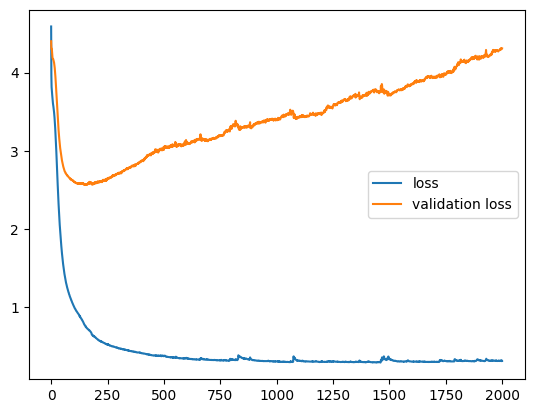

In [75]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

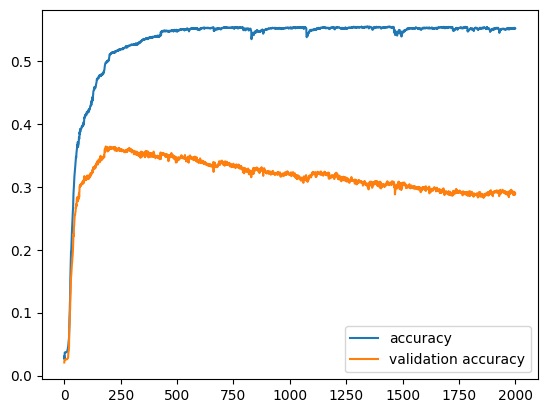

In [76]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [ ]:
#### Trained a language model to predict the next word in a sentence by memorizing a bunch of sentences.